# Analysis of the data collected by GCOZ

In [162]:
import json
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [163]:
def iqr_averages(df : pd.DataFrame):
    averages = []
    for col in df:
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        iqr = 1.3 * (q3 - q1)
        filter = (df[col] >= q1 - 1.5*iqr) & (df[col] <= q3 + 1.5*iqr)
        averages.append(df[col].loc[filter].mean())
    return averages

def reg_averages(df : pd.DataFrame):
    averages = []
    for col in df:
        averages.append(df[col].mean())
    return averages

In [181]:
_GAME = 'Dirt Rally' # replace with the string you gave the profiler on execution
_RUN  = '0' # replace with the number generated by the profiler on saving
_GRAPHS = f'graphs/{_GAME}/run_{_RUN}'

In [165]:
with open(f'data/{_GAME}/run_{_RUN}/Frametimes.json') as infile:
    times = json.load(infile)

with open(f'data/{_GAME}/run_{_RUN}/MethodDurations.json') as infile:
    durations =json.load(infile)

with open(f'data/{_GAME}/run_{_RUN}/ThreadIDs.json') as infile:
    ids = json.load(infile)

In [166]:
# Create Directory for resulting graphs
from pathlib import Path
Path(_GRAPHS).mkdir(parents=True, exist_ok=True)

## Remove uninteresting methods from data

In [167]:
# get the average Durations above 1000ns, as only these methods get delayed in profiling
averageDurations = {}
for key, data in durations.items():
    avg = np.mean(data)
    if(avg > 1000 or key == 'End'):
        averageDurations[key] = avg
print(json.dumps(averageDurations, indent=4))

{
    "CheckFormatSupport": 4100.0,
    "CreateShaderResourceView": 41000.0,
    "CreateTexture2D": 165350.0,
    "DrawIndexed": 1054.6440677966102
}


In [168]:
temp = {}

for key, data in times.items():
    if(key in averageDurations or key == "All"):
        print(key)
        temp[key] = pd.DataFrame(data).div(1e6)
times = temp

All
CheckFormatSupport
CreateShaderResourceView
CreateTexture2D
DrawIndexed


In [169]:
all = pd.DataFrame(times["All"])
all.describe()

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.832570,3.155949,3.088396,3.243204,3.270403,3.341595,3.415133,3.519820,3.661927,3.707789
std,0.361120,0.427774,0.359321,0.415431,0.382486,0.397920,0.358616,0.376910,0.416576,0.386137
min,2.085400,2.222100,2.312500,2.400100,2.470000,2.575700,2.674200,2.782900,2.880400,2.951900
25%,2.610775,2.884575,2.842300,2.967050,3.021875,3.102375,3.191025,3.279975,3.410025,3.470825
50%,2.798850,3.097400,3.068100,3.186200,3.233850,3.295300,3.389200,3.489900,3.611150,3.698050
75%,3.025225,3.411625,3.308900,3.472950,3.472950,3.541025,3.610000,3.713875,3.849550,3.902375
max,4.581100,5.684600,4.689400,4.993000,5.593900,6.335700,5.345200,5.263200,5.254000,5.852400


## Inspect Frametime Data

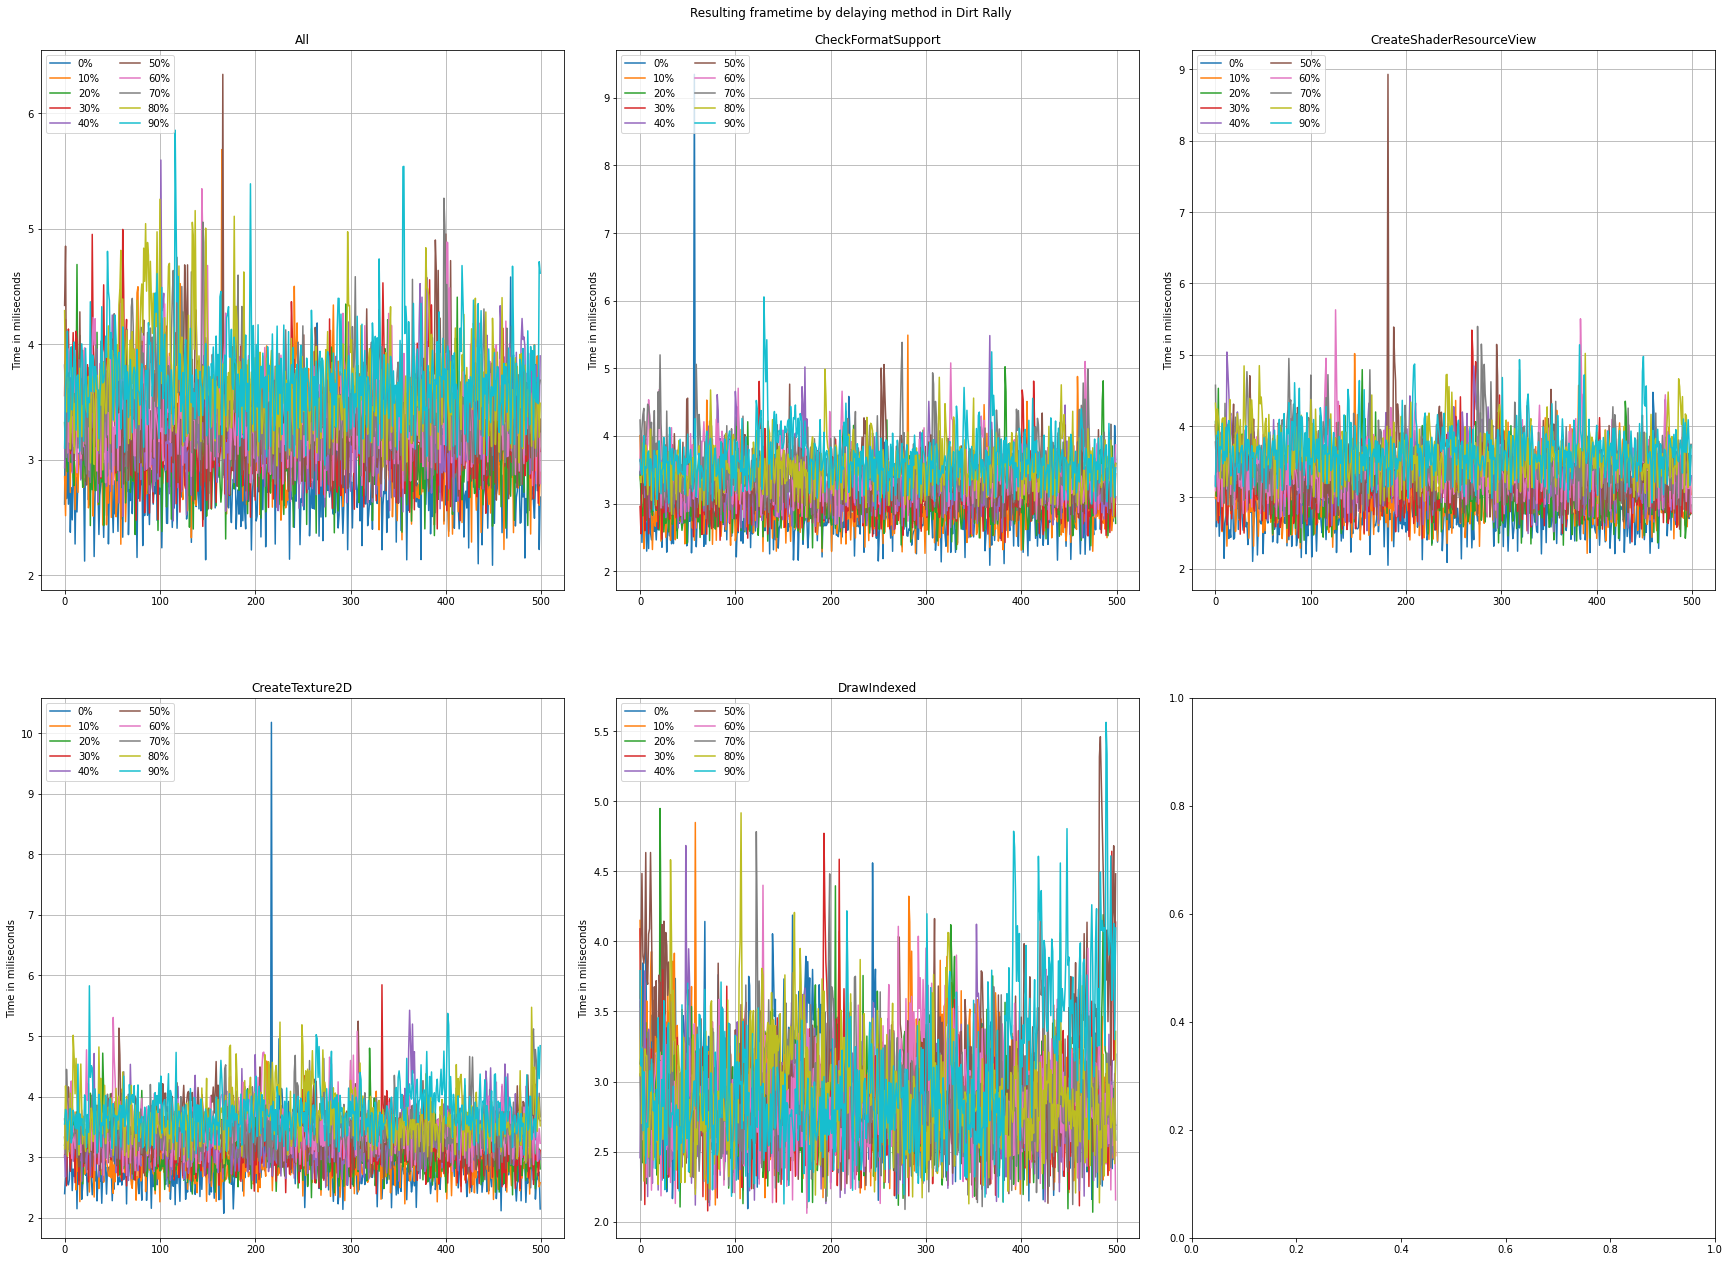

In [170]:
rowN, colN = (int(np.ceil(len(times.keys())/3)), 3)
fig, axs = plt.subplots(ncols = colN, nrows = rowN, figsize = (30, 20))
fig.suptitle(f"Resulting frametime by delaying method in {_GAME}")
fig.subplots_adjust(top=.95)

row, col = 0, 0
for key in times.keys():
    times[key].plot(ax=axs[row, col])
    axs[row, col].set_title(key)
    axs[row, col].legend(loc='upper left', ncols = 2)
    axs[row, col].grid()
    axs[row, col].set_ylabel('Time in miliseconds')
    col += 1
    if(col >= colN):
        col = 0
        row += 1

plt.subplots_adjust(wspace=.1)
plt.savefig(f'{_GRAPHS}/AllFrametimesLine.png', bbox_inches = 'tight')

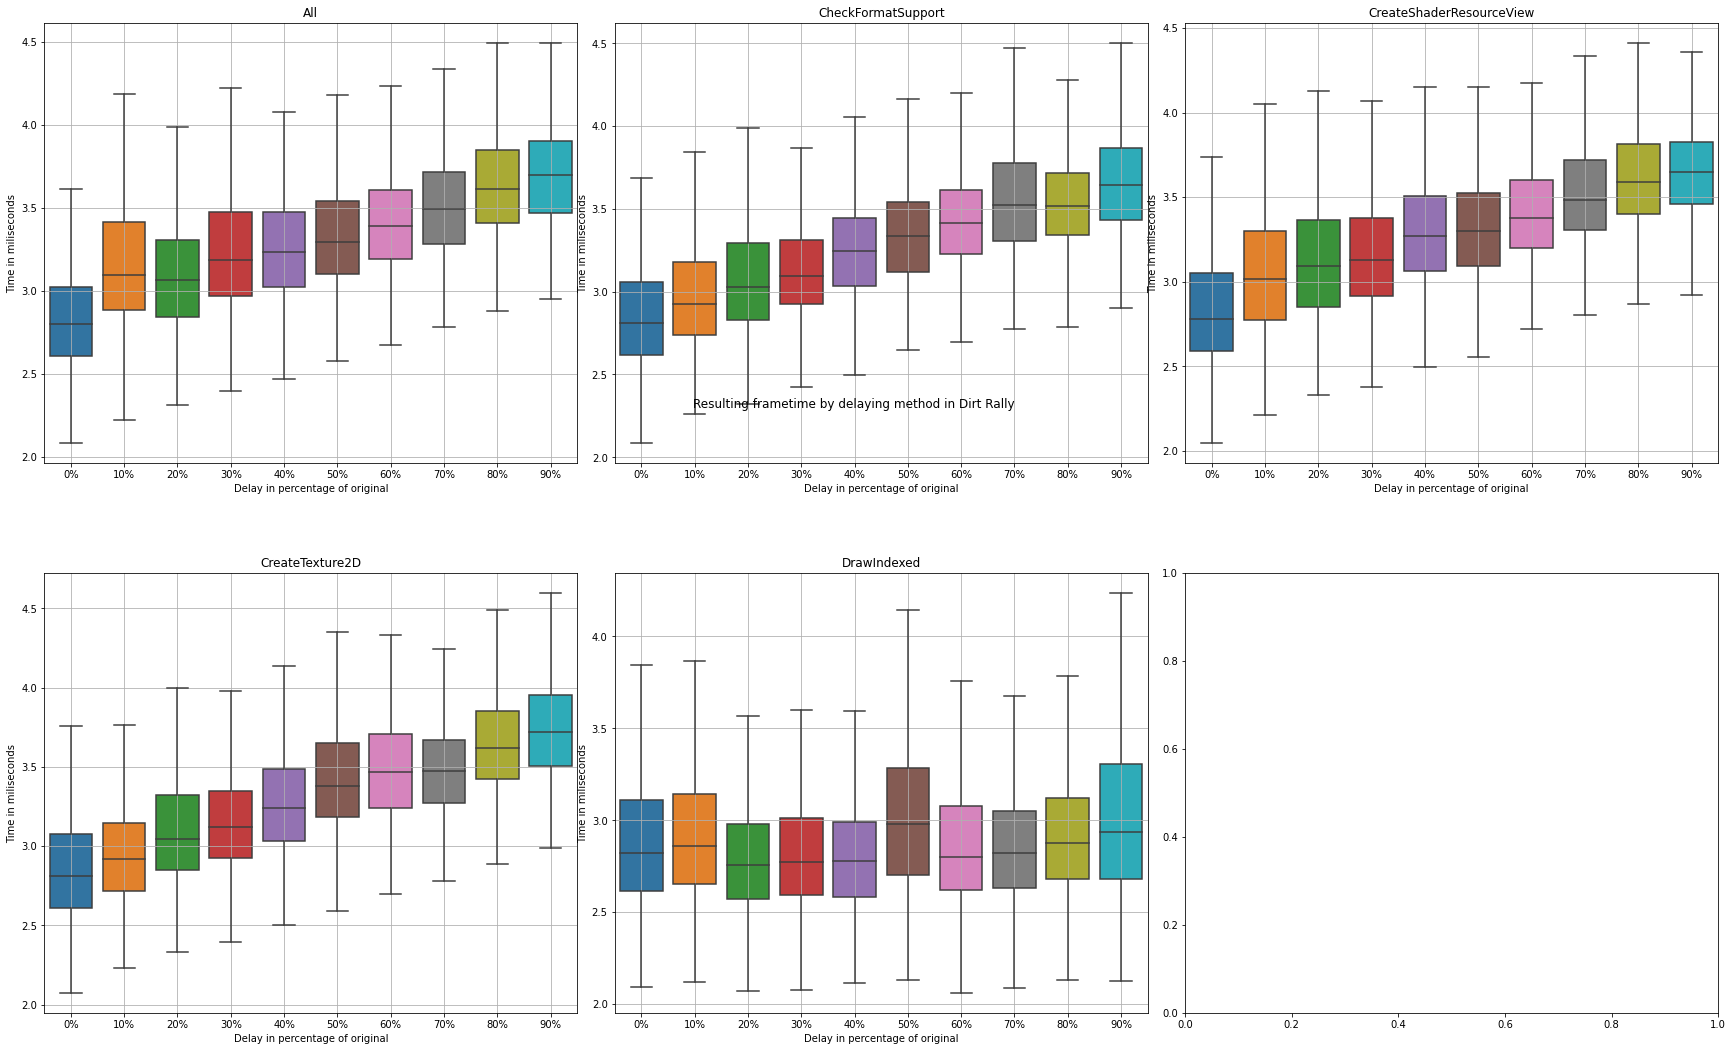

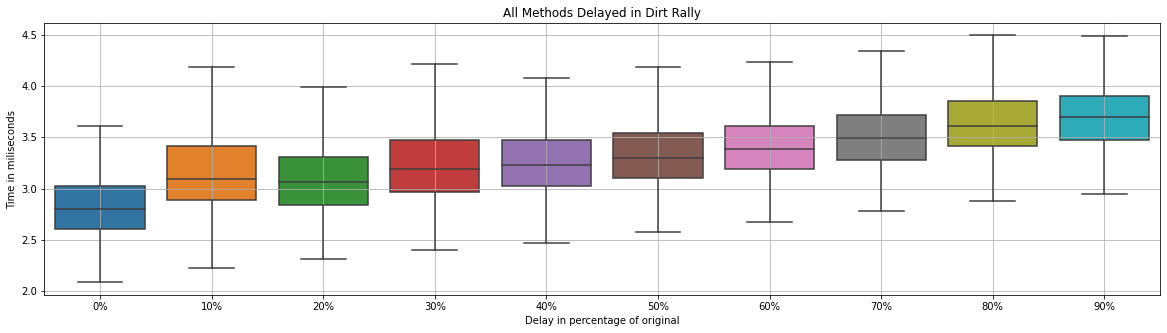

In [171]:
rowN, colN = (int(np.ceil(len(times.keys())/3)), 3)
fig, axs = plt.subplots(ncols = colN, nrows = rowN, figsize = (30, 10))
fig.suptitle(f"Resulting frametime by delaying method in {_GAME}")

row, col = 0, 0
for key in times.keys():
    sb.boxplot(times[key], showfliers=False , ax=axs[row, col])
    axs[row, col].set_title(key)
    axs[row, col].grid()
    axs[row, col].set_ylabel('Time in miliseconds')
    axs[row, col].set_xlabel('Delay in percentage of original')
    col += 1
    if(col >= colN):
        col = 0
        row += 1

plt.subplots_adjust(hspace=.25, wspace=.07, top=1.5)

sfig, saxs = plt.subplots(1, 1, figsize = (20, 5))
sb.boxplot(times["All"], showfliers=False , ax=saxs)
saxs.set_title(f'All Methods Delayed in {_GAME}')
saxs.grid()
saxs.set_ylabel('Time in miliseconds')
saxs.set_xlabel('Delay in percentage of original')
plt.savefig(f'{_GRAPHS}/SingleFrametimesBox.png', bbox_inches = 'tight')

## Average the frametime data

In [172]:
averageFrametime = pd.DataFrame()
for method, df in times.items():
    averageFrametime[method] = {}
    averageFrametime[method] = iqr_averages(pd.DataFrame(times[method]))
    for delay, data in df.items():
        pass
averageFrametime = averageFrametime.transpose()
averageFrametime.columns = ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]

averageFrametime

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%
All,2.807616,3.136813,3.077571,3.220447,3.255878,3.312393,3.397544,3.493730,3.621883,3.687706
CheckFormatSupport,2.841702,2.956935,3.050873,3.105854,3.245966,3.337693,3.428431,3.542389,3.517542,3.649003
CreateShaderResourceView,2.824869,3.044598,3.122955,3.149401,3.296107,3.302436,3.385590,3.507719,3.602025,3.636794
CreateTexture2D,2.847298,2.940170,3.099640,3.135311,3.251820,3.413907,3.468381,3.457557,3.635056,3.730288
DrawIndexed,2.864249,2.902041,2.785873,2.801382,2.789186,3.009147,2.853019,2.845295,2.898109,3.011381


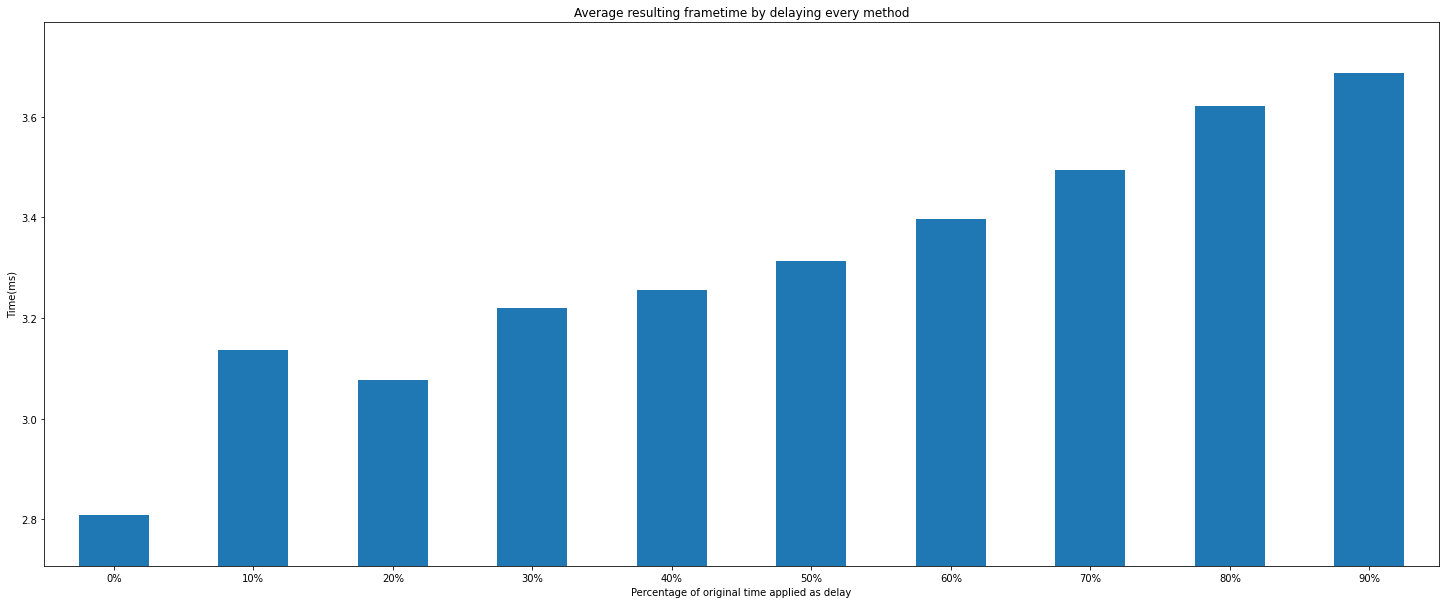

In [173]:
fig, axs = plt.subplots(figsize = (25, 10))
averageFrametime.transpose()["All"].plot(ax=axs, kind='bar', ylim=(min(averageFrametime.transpose()["All"] - .1), max(averageFrametime.transpose()["All"] + .1)))
axs.set_title('Average resulting frametime by delaying every method')
axs.set_ylabel('Time(ms)')
axs.set_xlabel('Percentage of original time applied as delay')
plt.xticks(rotation=0, horizontalalignment='center')

plt.savefig(f'{_GRAPHS}/BaselineAverage.png')

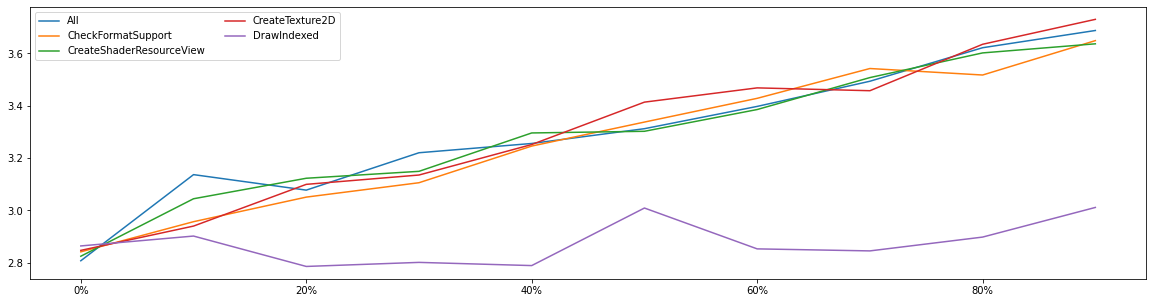

In [174]:
fig, axs = plt.subplots(1, 1, figsize=(20,5))
averageFrametime.transpose().plot(ax=axs).legend(loc='upper left', ncols=2)

In [175]:
allMethods = averageFrametime.transpose()["All"]
singleMethods = averageFrametime.transpose().drop(columns=['All'])

In [176]:
allMethods

0%     2.807616
10%    3.136813
20%    3.077571
30%    3.220447
40%    3.255878
50%    3.312393
60%    3.397544
70%    3.493730
80%    3.621883
90%    3.687706
Name: All, dtype: float64

In [177]:
singleMethods

,CheckFormatSupport,CreateShaderResourceView,CreateTexture2D,DrawIndexed
0%,2.841702,2.824869,2.847298,2.864249
10%,2.956935,3.044598,2.940170,2.902041
20%,3.050873,3.122955,3.099640,2.785873
30%,3.105854,3.149401,3.135311,2.801382
40%,3.245966,3.296107,3.251820,2.789186
50%,3.337693,3.302436,3.413907,3.009147
60%,3.428431,3.385590,3.468381,2.853019
70%,3.542389,3.507719,3.457557,2.845295
80%,3.517542,3.602025,3.635056,2.898109
90%,3.649003,3.636794,3.730288,3.011381


In [178]:
differences = np.abs(singleMethods.sub(allMethods, axis='rows'))
differences

,CheckFormatSupport,CreateShaderResourceView,CreateTexture2D,DrawIndexed
0%,0.034086,0.017253,0.039682,0.056633
10%,0.179878,0.092215,0.196643,0.234773
20%,0.026697,0.045384,0.022069,0.291698
30%,0.114593,0.071047,0.085136,0.419066
40%,0.009912,0.040228,0.004058,0.466693
50%,0.025299,0.009957,0.101514,0.303246
60%,0.030887,0.011953,0.070838,0.544525
70%,0.048659,0.013990,0.036173,0.648434
80%,0.104341,0.019858,0.013173,0.723774
90%,0.038704,0.050912,0.042582,0.676325


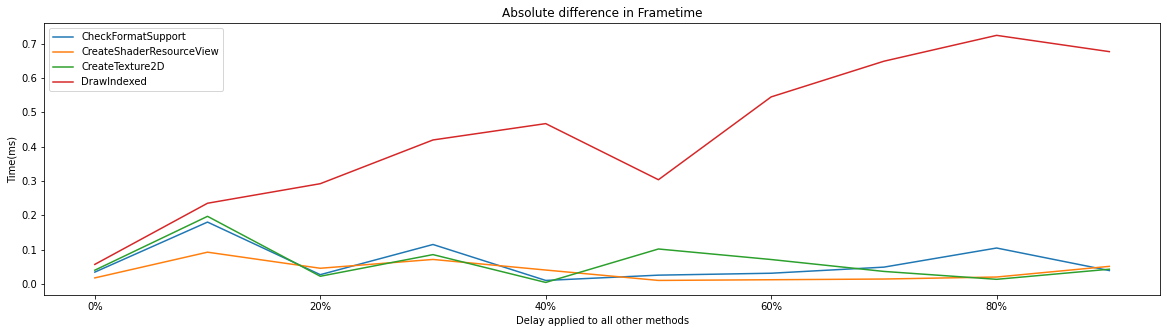

In [179]:
fig, axs  = plt.subplots(1, 1, figsize=(20,5))
axs.set_title('Absolute difference in Frametime')
axs.set_ylabel('Time(ms)')
axs.set_xlabel('Delay applied to all other methods')
differences.plot(ax=axs)
plt.savefig(f'{_GRAPHS}/resultAbs.png')

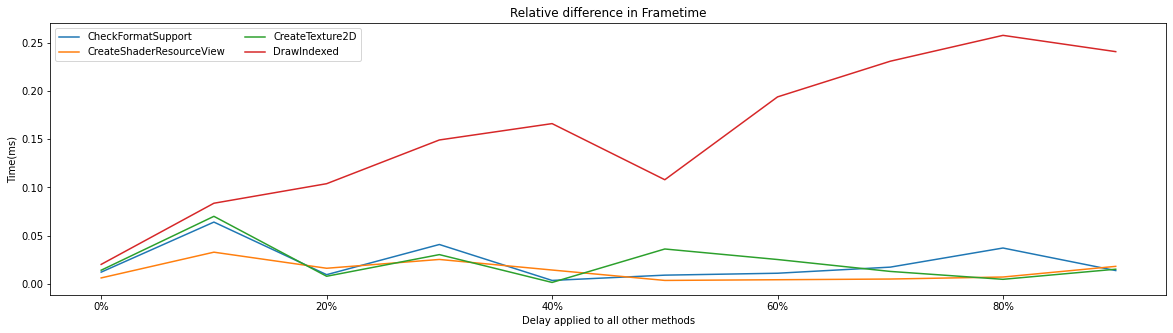

In [180]:
results = differences.div(allMethods["0%"], axis=0)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.grid()
axs.set_title('Relative difference in Frametime')
axs.set_ylabel('Time(ms)')
axs.set_xlabel('Delay applied to all other methods')

results.plot(ax=axs).legend(loc = 'upper left', ncols = 2)
plt.savefig(f'{_GRAPHS}/resultRel.png')